In [1]:
import os
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


#### Data distribution


In [2]:
classes = dict(Counter([i.split('_')[0] for i in os.listdir('all/')]))

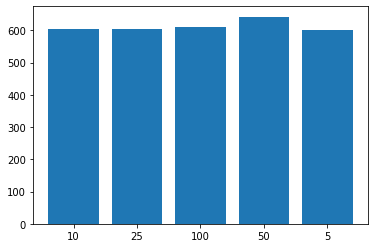

In [3]:
plt.bar(*zip(*classes.items()))
plt.show()

In [4]:
#for coin in os.listdir('all/'):
#    shutil.copy('all/'+coin, 'coin_dataset/'+coin.split('_')[0])

In [5]:
batch_size = 32
img_height = 180
img_width = 180


#### test train split

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "coin_dataset/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3059 files belonging to 5 classes.
Using 2448 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'coin_dataset/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3059 files belonging to 5 classes.
Using 611 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['10', '100', '25', '5', '50']


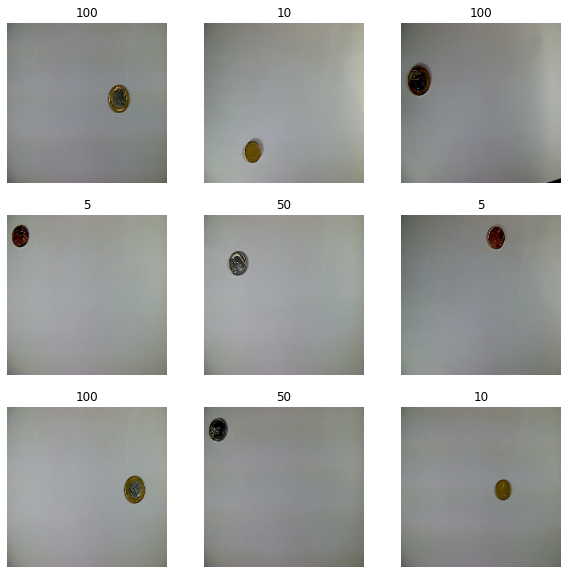

In [9]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.00036311045 0.998911


### Models

In [12]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
77/77 [==============================] - 87s 1s/step - loss: 1.6179 - accuracy: 0.2128 - val_loss: 1.5830 - val_accuracy: 0.3028
Epoch 2/10
77/77 [==============================] - 46s 597ms/step - loss: 1.3753 - accuracy: 0.4334 - val_loss: 1.2828 - val_accuracy: 0.5303
Epoch 3/10
77/77 [==============================] - 46s 595ms/step - loss: 0.9286 - accuracy: 0.6569 - val_loss: 0.9796 - val_accuracy: 0.6923
Epoch 4/10
77/77 [==============================] - 46s 593ms/step - loss: 0.6354 - accuracy: 0.7806 - val_loss: 0.9302 - val_accuracy: 0.7529
Epoch 5/10
77/77 [==============================] - 46s 594ms/step - loss: 0.4605 - accuracy: 0.8374 - val_loss: 0.9795 - val_accuracy: 0.7823
Epoch 6/10
77/77 [==============================] - 46s 595ms/step - loss: 0.3099 - accuracy: 0.8840 - val_loss: 1.0400 - val_accuracy: 0.8052
Epoch 7/10
77/77 [==============================] - 46s 594ms/step - loss: 0.2338 - accuracy: 0.9244 - val_loss: 1.2235 - val_accuracy: 0.7921
Ep

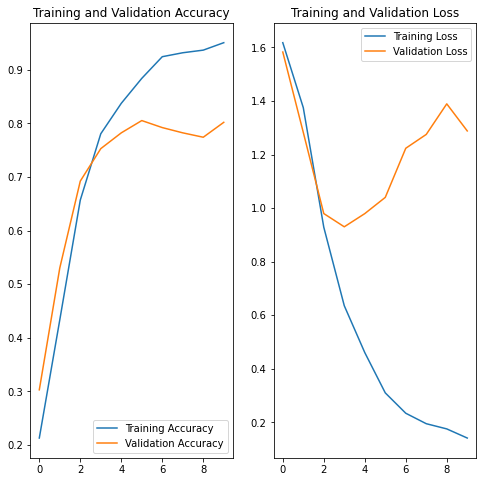

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:

img = keras.preprocessing.image.load_img(
    'coin_dataset/5/5_1477145448.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to 5 with a 97.33 percent confidence.
